We follow up on first example, but with a more concrete quantum system: the nitrogen vacancy (NV) center in diamond. NVs are probably the most known color centers, due to its extensive research in quantum technologies. Here, however, we will focus on QuaCCAToo's usage rather than the physics of the NV itself. For more detailed information about NVs, we recommend:

[1] E. V. Levine, et al., Principles and techniques of the quantum diamond microscope, Nanophotonics 8, 1945 (2019).

[2] S. Pezzagna and J. Meijer, Quantum computer based on color centers in diamond, Applied Physics Reviews 8,011308 (2021).

**Table of contents**<a id='toc0_'></a>    
- 1. [Energy Levels](#toc1_)    
- 2. [Rabi Oscillations of Electronic Spin](#toc2_)    
- 3. [Ramsey Experiment](#toc3_)    
- 4. [Pulsed Optically Detected Magnetic Resonance (PODMR)](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from qutip import fock_dm, tensor, qeye

from quaccatoo import plot_energy_B0, NV, Rabi, Ramsey, PMR, fit_rabi, fit_two_lorentz_sym, fit_two_sinc2_sym, Analysis, ExpData

# 1. <a id='toc1_'></a>[Energy Levels](#toc0_)

We begin defining the quantum system from the predefined NV class in quaccatoo. The class has only two mandatory parameters, the nitrogen isotope $^{14}\text{N}$ or $^{15}\text{N}$ and the magnetic field in mT. Optionally, the user can define a misalignment angle between the NV axis and the magnetic field, alternative magnetic field units, alternative Hamiltonian units, or collapse operators for the pulsed experiments.

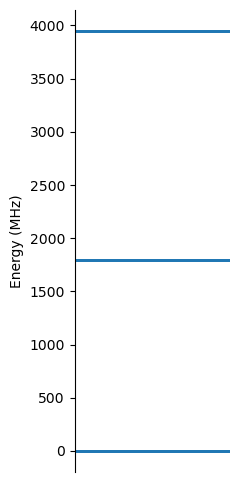

In [2]:
# define the NV center system
qsys = NV(
    B0 = 38.4, # external magnetic field in mT
    N=15, # here we start considering the 15N nuclear spin
    units_B0='mT', # the unit of the external magnetic field
)

# to visualize the energy levels we use the plot_energy method
qsys.plot_energy()

Here we observe the three electronic energy levels of the NV center: $m_s=0,-1,+1$. To be able to see the nuclear levels splitting, we need to specify a smaller energy range in the plot_energy method.

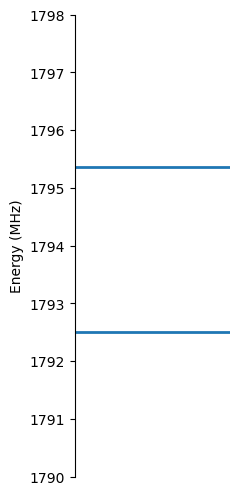

In [3]:
qsys.plot_energy(energy_lim=[1790, 1798])

Now, the splitting from the $^{15}\text{N}$ nuclear spin is observed.

So far we considered $B_0=40$ mT, but if we want to see how these energy levels change as a function of the external magnetic field we can use the plot_energy_B0 function.

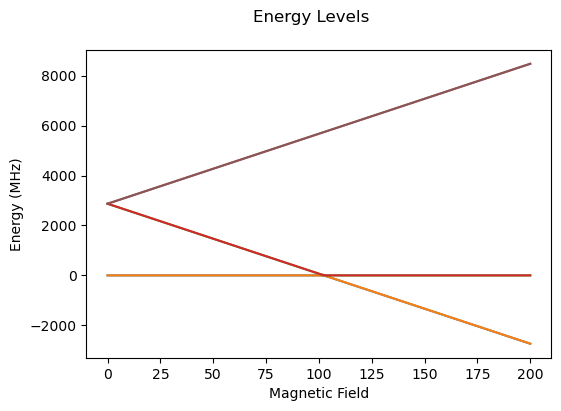

In [4]:
# define the range of B0 values where we want to plot the energy levels
B0_array = np.linspace(0, 200, 100)

# plot the energy levels as a function of the external magnetic field
plot_energy_B0(
    B0 = B0_array,
    H0 = [NV(N=15, B0=B, units_B0='mT').H0 for B in B0_array] # here we calculate the Hamiltonian for each B0 value
)

As expected, the $m_s=+1$ grows linearly with the field, while the $m_s=-1$ decreases linearly and $m_s=0$ level is not affected by the field. After 100 mT, the level anticrossing occurs.

# 2. <a id='toc2_'></a>[Rabi Oscillations of Electronic Spin](#toc0_)

Just like in the previous notebook, the first experiment usually conducted is Rabi oscillations. In this case, $H_1$ and the resonant frequency of the pulse are not as trivial as before. The user can define their own parameters, but the NV class has a standard interaction Hamiltonian
$$ H_1 = S_x \otimes \mathbb{1}, $$
which can be obtained by the MW_H1 method. While the resonant frequencies for the $m_s=0 \rightarrow -1$ and $m_s=0 \rightarrow +1$ can be obtained from MW_freqs method, which takes the average between the two nuclear spin states. Again, we will consider a square cosine wave for the pulse.

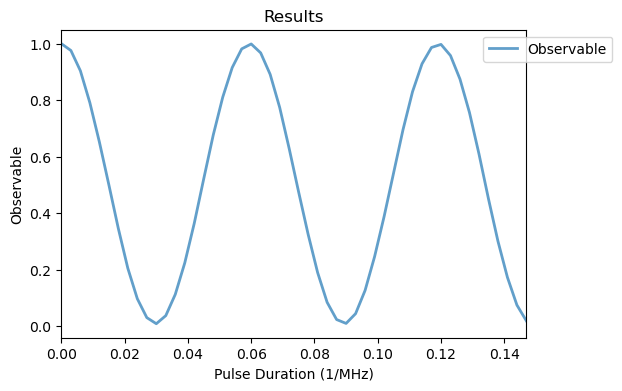

In [5]:
w1 = 16.72 # typical NV Rabi frequency in MHz

# define the Rabi experiment
rabi_exp_1 = Rabi(
    pulse_duration = np.arange(0, 0.15, 3e-3), # pulse duration in us
    system = qsys, # NV center system
    H1 = w1*qsys.MW_H1, # control Hamiltonian
    pulse_params = {'f_pulse': qsys.MW_freqs[0]} # MW frequency for the ms=0 --> ms=-1 state transition
)

# run the experiment
rabi_exp_1.run()
# plot results

rabi_analysis = Analysis(rabi_exp_1)
rabi_analysis.plot_results()

If we want to compare with the simulation with experimental data, we can use the ExpData class to load it from .dat file.

LinregressResult(slope=np.float64(2.5895433099645087), intercept=np.float64(-2.0453606017177943), rvalue=np.float64(0.9872724329677315), pvalue=np.float64(5.450831497929558e-40), stderr=np.float64(0.06020976750546206), intercept_stderr=np.float64(0.059969969677619944))

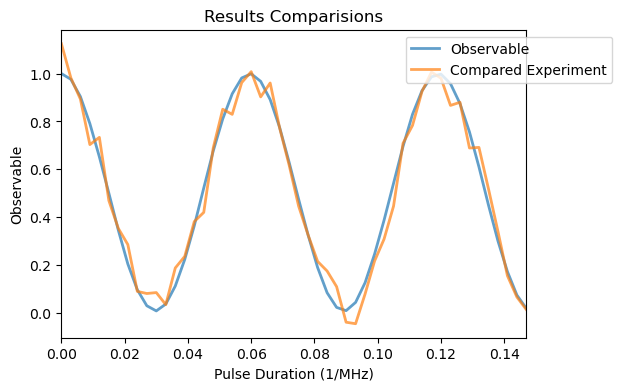

In [6]:
exp_data = ExpData(file_path='./ExpData_examples/Ex02_NV_rabi.dat')
exp_data.variable *= 1e6 # convert the variable from s to us

rabi_analysis.compare_with(exp_data)
rabi_analysis.plot_comparison()
rabi_analysis.pearson

In this case, we observe a strong correlation of the simulation and experimental data with an rvalue of 0.987. The standard observable for the NV is the population in the $m_s=0$ given by the fluorescence. To see the populations of the other two states $m_s=\pm 1$, we need to redefine the system observables and define a new Rabi experiment.

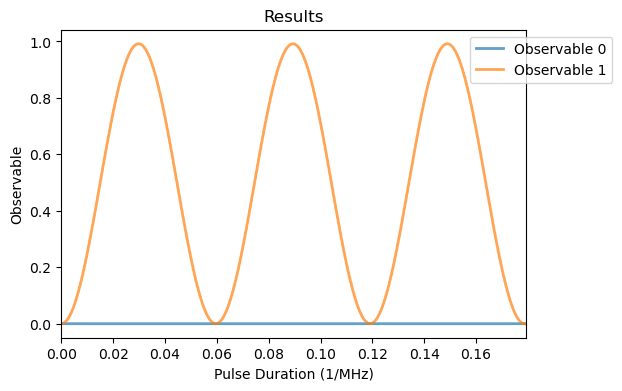

In [7]:
qsys.observable = [tensor(fock_dm(3, 0), qeye(2)), tensor(fock_dm(3, 2), qeye(2))]

# define the Rabi experiment
rabi_exp_2 = Rabi(
    pulse_duration = np.linspace(0, 3/w1, 1000),
    system = qsys, 
    H1 = w1*qsys.MW_H1,
    pulse_params = {'f_pulse': qsys.MW_freqs[0]} # MW frequency for the ms=0 --> ms=-1 state transition
)

# run the experiment
rabi_exp_2.run()
Analysis(rabi_exp_2).plot_results()

Note that population of the $m_s=+1$ remains 0, as we are using the $m_s=0 \rightarrow -1$ resonant frequency, while the $m_s=-1$ population oscillates with the same frequency as the $m_s=0$ population, but with opposite sign. If we used the other resonant frequency, the $m_s=+1$ population would oscillate but $m_s=-1$ would remain 0.

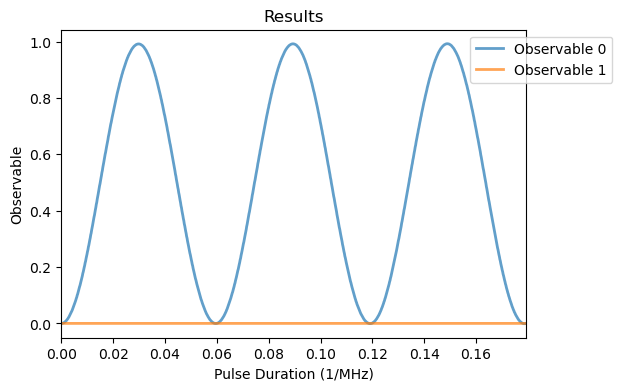

In [8]:
rabi_exp_3 = Rabi(
    pulse_duration = np.linspace(0, 3/w1, 1000),
    system = qsys,
    H1 = w1*qsys.MW_H1,
    pulse_params = {'f_pulse': qsys.MW_freqs[1]} # MW frequency for the ms=0 --> ms=+1 state transition
)

# run the experiment
rabi_exp_3.run()
Analysis(rabi_exp_3).plot_results()

Finally, by running a fit of the observable we can extract the $\pi$-pulse duration.

np.float64(0.029782954578184768)

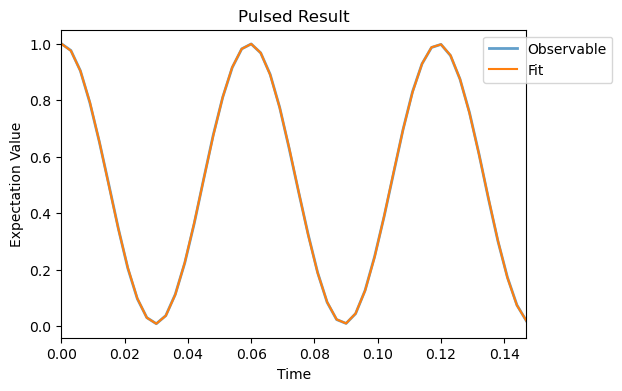

In [9]:
qsys.observable = tensor(fock_dm(3,0), qeye(2)) # !!! This line doesn't change the already conducted simulation rabi_exp_1. We can just delete it. !!!

# call the Analysis class for the rabi experiment
rabi_analysis = Analysis(rabi_exp_1)

rabi_analysis.run_fit(
    fit_function = fit_rabi, # here we use the predefined fit_rabi function
    guess = [.5, 1/2/w1, .5, 0], # we can provide an initial guess for the fit parameters, check the Analysis module for the order of the parameters
    )

# plot the fit results
rabi_analysis.plot_fit()
# print the fitted pi-pulse duration
rabi_analysis.fit[1]

As expected the $\pi$-pulse duration is very close to $1/(2\omega_1)$.

# 3. <a id='toc3_'></a>[Ramsey Experiment](#toc0_)

A simple, but important, pulse sequence in quantum sensing is the Ramsey experiment. It measures the accumulated phase difference in the two levels, by applying a $\pi/2$ pulse, waiting for a time $\tau$ and applying another $\pi/2$ pulse, then measuring the population in the $m_s=0$ state.

/home/a3459/Documents/QuaCCAToo_main/quaccatoo/QSys/NVSys.py:105: UserWarning: No units for the magnetic field were given. The magnetic field will be considered in mT.
  warnings.warn("No units for the magnetic field were given. The magnetic field will be considered in mT.")


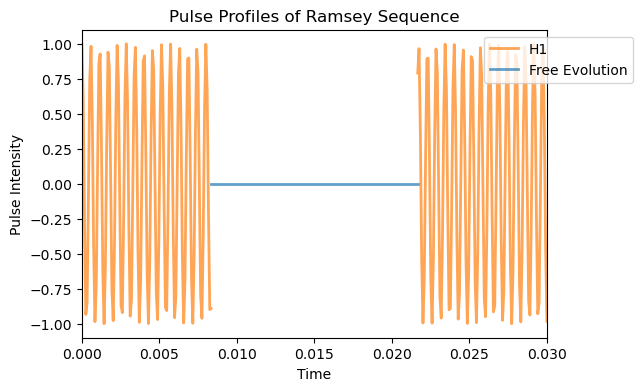

In [10]:
# define the NV center system same as before
qsys = NV(
    N=15,
    B0 = 40
)

w1 = 30 # Rabi frequency in MHz

# define the Ramsey experiment
ramsey_exp = Ramsey(
    free_duration = np.linspace(1/2/w1, 3, 500), # free evolution time in us
    pi_pulse_duration = 1/2/w1, # pi-pulse duration in us
    system = qsys, # NV center system
    H1 = w1*qsys.MW_H1, # control Hamiltonian
    pulse_params = {'f_pulse': qsys.MW_freqs[0]} # MW frequency for the ms=0 --> ms=-1 state transition
)

# plot the pulses
ramsey_exp.plot_pulses(tau=.03)

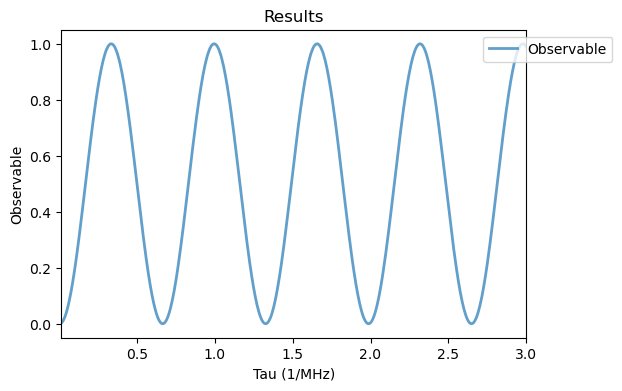

In [11]:
# run the experiment and plot results
ramsey_exp.run()
Analysis(ramsey_exp).plot_results()

We could fit the results again with a period oscillation, but to illustrate a different method we will use the FFT from quaccatoo.

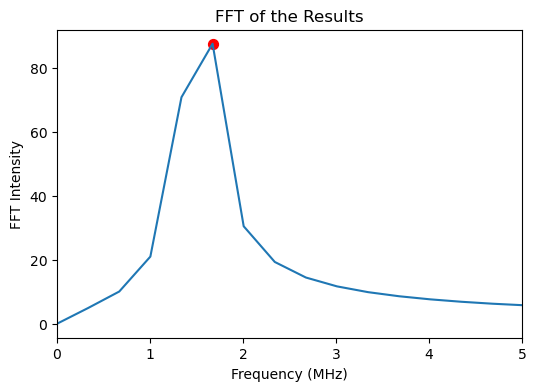

In [12]:
ramsey_analysis = Analysis(ramsey_exp)
# run the FFT
ramsey_analysis.run_FFT()
# extract peaks from the FFT spectrum
ramsey_analysis.get_peaks_FFT()
# plot the FFT results
ramsey_analysis.plot_FFT(freq_lim=[0,5])

The frequencies are too spaced in the FFT due to the low range of $\tau$, but we can see the main peak corresponds to approximately half of the hyperfine splitting of the nuclear spin $a_{||}/2=1.515$ MHz, as expected.

# 4. <a id='toc4_'></a>[Pulsed Optically Detected Magnetic Resonance (pODMR)](#toc0_)

To further study the energy levels of the system, we simulate a pODMR experiment. A pODMR experiment is simply composed by a pulse of varying frequency, thus when it corresponds to a resonance, a change in the observable is expected.

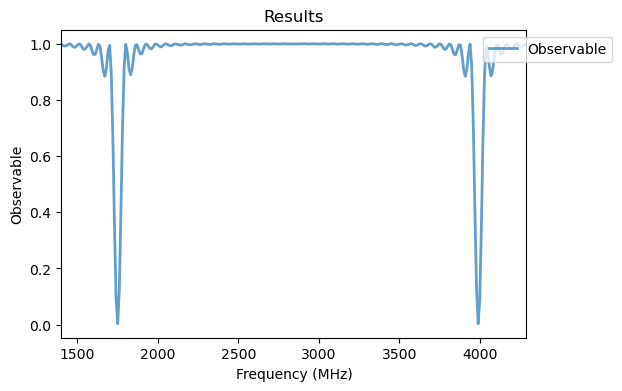

In [13]:
# define the NV center system same as before
qsys = NV(
    N=15,
    B0 = 40
)

w1 = 30 # Rabi frequency in MHz

# define the PODMR experiment
podmr_exp_1 = PMR(
    frequencies = np.arange(1400, 4300, 10), # frequencies to scan in MHz
    pulse_duration = 1/2/w1, # pulse duration
    system = qsys, # NV center system
    H1 = w1*qsys.MW_H1, # control Hamiltonian
)

# run and plot the experiment
podmr_exp_1.run()
Analysis(podmr_exp_1).plot_results() # !!! The x-axis for pODMR is frequency, not the time. Changed in the class method!!!

Two resonances can be observed, corresponding to the two electronic spin transitions and with a splitting given by the Zeeman interaction with the external magnetic field. To see the nuclear spin splitting, we need to reduce the Rabi frequency to have a better frequency resolution.

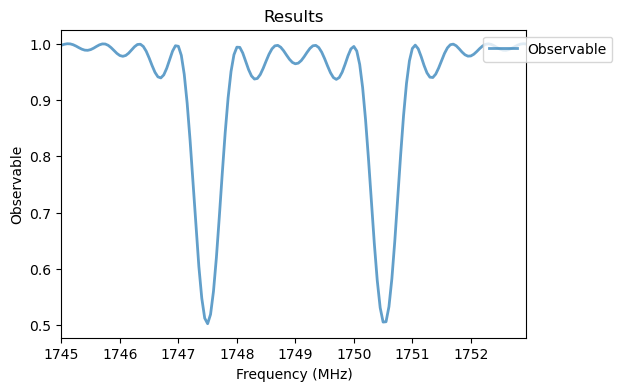

In [14]:
w1 = 0.3 # Rabi frequency in MHz

# define the PODMR experiment
podmr_exp_2 = PMR(
    frequencies = np.arange(1745, 1753, 0.05), # frequencies to scan in MHz
    pulse_duration = 1/2/w1, # pulse duration
    system = qsys, # NV center system
    H1 = w1*qsys.MW_H1, # control Hamiltonian
)

# run and plot the experiment
podmr_exp_2.run()
Analysis(podmr_exp_2).plot_results()

The two resonances now correspond to the two nuclear spin transitions. To get the splitting, we can fit them with Lorentzian Functions.

array([5.40005980e-01, 1.99208531e-01, 1.74900876e+03, 3.02908339e+00,
       1.00483807e+00])

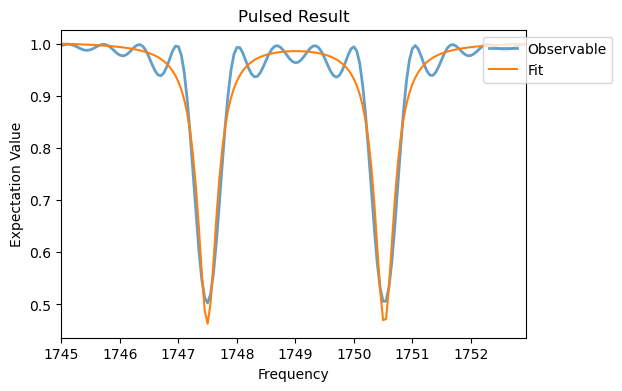

In [15]:
podmr_analysis = Analysis(podmr_exp_2)

# run the fit
podmr_analysis.run_fit(
    fit_function = fit_two_lorentz_sym, # we use the same fit function as for the Rabi experiment
    guess = [.5, .2, 1749, 3, 1], # initial guess for the fit parameters
    )

podmr_analysis.plot_fit(xlabel='Frequency')
podmr_analysis.fit

From the fit we can extract the parallel component of the hyperfine splitting $a_{||}=3.03$ MHz. However, the commonly used Lorentzian function does not completely describes all features of the resonace. A better fit is provided with sinc function.

array([4.96798394e-01, 3.00666705e-01, 1.74900877e+03, 3.02839371e+00,
       9.99168986e-01])

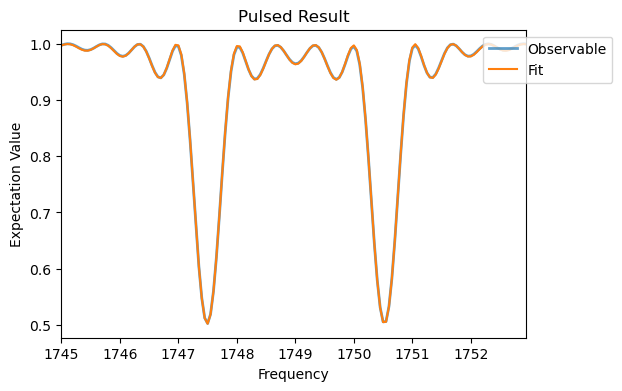

In [16]:
podmr_analysis_2 = Analysis(podmr_exp_2)

# run the fit
podmr_analysis_2.run_fit(
    fit_function = fit_two_sinc2_sym, # we use the same fit function as for the Rabi experiment
    guess = [.5, .4, 1749, 3, 1], # initial guess for the fit parameters
    )

podmr_analysis_2.plot_fit(xlabel='Frequency')
podmr_analysis_2.fit

Visually is clear that the sinc function is better fit of the simulation data than the Lorentzian funciton, but to compare them in number we can use the fit_cov attribute to calculate the trace of the of the covariance matrix squared.

In [17]:
print(np.trace(podmr_analysis.fit_cov**2))
print(np.trace(podmr_analysis_2.fit_cov**2))

2.2199606415039342e-08
8.939474454427516e-15
